In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import cv2
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mmseg.registry import MODELS
from mmengine.config import Config
from mmengine.runner import Runner
from mmengine.model import BaseModule
from mmengine.registry import init_default_scope
init_default_scope('mmseg')
from mmseg.models.segmentors import EncoderDecoder
from mmseg.datasets.acdc import ACDCDataset
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.utils import save_image
import os
from torch.cuda import amp

/BS/DApt/work/build/conda/envs/seg2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_dataloader():
    dataloaders = []
    val_dataloaders = []
    #Fog
    dataset_config = '/BS/DApt/work/project/segformer_test/local_config/_base_/datasets/acdc_fog.py'
    cfg = Config.fromfile(dataset_config)
    dl1 = Runner.build_dataloader(cfg.train_dataloader)
    val_dl1 = Runner.build_dataloader(cfg.val_dataloader)
    dataloaders.append(dl1)
    val_dataloaders.append(val_dl1)
    #Night
    dataset_config = '/BS/DApt/work/project/segformer_test/local_config/_base_/datasets/acdc_night.py'
    cfg = Config.fromfile(dataset_config)
    dl2 = Runner.build_dataloader(cfg.train_dataloader)
    val_dl2 = Runner.build_dataloader(cfg.val_dataloader)
    dataloaders.append(dl2)
    val_dataloaders.append(val_dl2)
    #Rain
    dataset_config = '/BS/DApt/work/project/segformer_test/local_config/_base_/datasets/acdc_rain.py'
    cfg = Config.fromfile(dataset_config)
    dl3 = Runner.build_dataloader(cfg.train_dataloader)
    val_dl3 = Runner.build_dataloader(cfg.val_dataloader)
    dataloaders.append(dl3)
    val_dataloaders.append(val_dl3)
    #Snow
    dataset_config = '/BS/DApt/work/project/segformer_test/local_config/_base_/datasets/acdc_snow.py'
    cfg = Config.fromfile(dataset_config)
    dl4 = Runner.build_dataloader(cfg.train_dataloader)
    val_dl4 = Runner.build_dataloader(cfg.val_dataloader)
    dataloaders.append(dl4)
    val_dataloaders.append(val_dl4)

    return dataloaders,val_dataloaders

In [3]:
dataloaders,val_dataloaders = load_dataloader()

In [4]:
def distribution_per_class_per_patch(data_loader):
    num_classes = 19
    patch_rows, patch_cols = 8, 8
    patch_h, patch_w = 1080 // patch_rows, 1920// patch_cols
    
    patches = []

    for batch_ndx, sample in enumerate(data_loader):
        seg_paths = [data_sample.seg_map_path for data_sample in sample['data_samples']]

        gts = []
        for imgs in seg_paths:
            # Read and convert the image
            img = cv2.imread(imgs)
            img = img[: ,:,0] # only taking 1 channel
            #print(img.shape)
            #resized_image = cv2.resize(img, (540,960 )) 
            resized_image = torch.tensor(img).unsqueeze(0)
            gts.append(resized_image)
        

        gt = torch.stack(gts, dim=0).cuda()
     
        unfold = torch.nn.Unfold(kernel_size=(1080 // patch_rows,1920 // patch_cols), stride=(1080 // patch_rows, 1920 // patch_cols))
        predx = gt.float()
        x = unfold(predx)  # B (c*p*p) no.of patches
        bs, c, h, w = predx.shape
        patch_h, patch_w = 1080 // patch_rows, 1920 // patch_cols
        num_patches = (h // patch_h) * (w // patch_w)
        a = x.reshape(bs, c, patch_h, patch_w, num_patches).permute(0, 4, 1, 2, 3)
        # a -> ( B no.of patches c p p )
        batch, num_patches, channels, patch_height, patch_width = a.shape
        z = a.reshape(batch * num_patches, patch_height * patch_width) # batch * num_patches -> total individual patches

        class_dist = torch.zeros(batch * num_patches, num_classes, device=z.device)
        
        for i in range(class_dist.shape[0]):
            for n in range(num_classes):
                class_dist[i, n] = (z[i] == n).sum() # z[i] represents one patch and (z[i] == n).sum() returns the no. of times class n is in z[i]
    
        # Normalize the distributions
        class_dist /= (class_dist.sum(dim=-1, keepdim=True) + 1e-12)
        class_dist = class_dist.reshape(bs , -1 , num_classes)
        
        patches.append(class_dist)
    
    # Concatenate all batches of patches
    patches = torch.cat(patches, dim=0)
    return patches

    

In [5]:
p = distribution_per_class_per_patch(dataloaders[1]) # b x no. of patches x no. of class
s = p.mean(dim = 0) # no. of patches x no. of class 64 x 19

In [6]:
s.shape

torch.Size([64, 19])

In [9]:
np.save('/BS/DApt/work/project/segformer_test/gt_entropies/night_v2.npy',s.cpu().numpy())

In [ ]:
s.shape

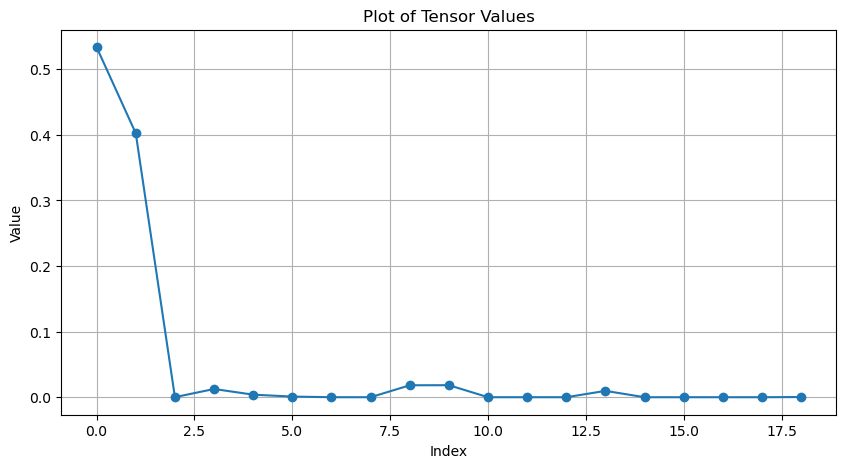

In [7]:
x = torch.arange(len(s[0].cpu().numpy()))
y = s[63].cpu().numpy()  # Convert to numpy array for matplotlib

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o')
plt.title('Plot of Tensor Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

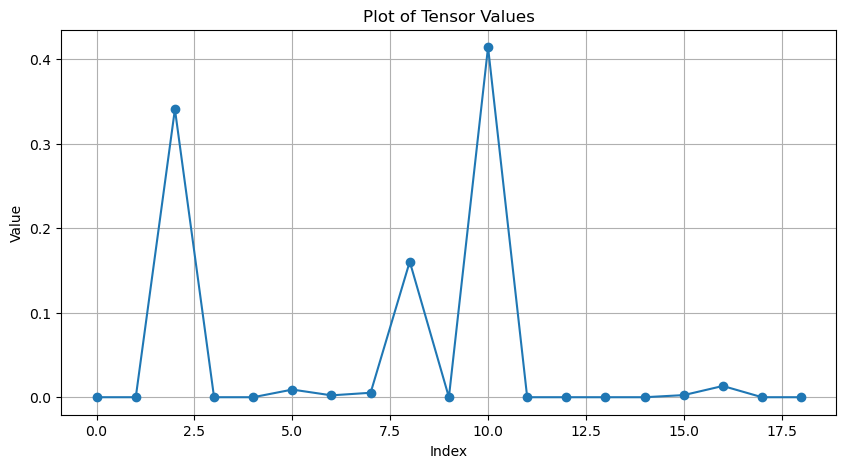

In [8]:
x = torch.arange(len(s[0].cpu().numpy()))
y = s[0].cpu().numpy()  # Convert to numpy array for matplotlib

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o')
plt.title('Plot of Tensor Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()